1️⃣ Installation & imports

In [1]:
import sys
!{sys.executable} -m pip install matplotlib seaborn numpy opencv-python scikit-learn webcolors scipy pandas

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pathlib import Path
import os
import glob
from collections import Counter, defaultdict
import cv2
from sklearn.cluster import KMeans
import webcolors
from scipy.spatial import distance
from concurrent.futures import ThreadPoolExecutor, as_completed
import time

print("✅ Librairies chargées")


✅ Librairies chargées


2️⃣ Configuration dataset & styles

In [2]:
STYLES = ['boheme', 'industriel', 'minimaliste', 'moderne', 'royal', 'rustique', 'vintage']
DATASET_PATH = Path('../dataset')  # adapter si nécessaire

WORKING_INFO = defaultdict(lambda: {'count': 0, 'images': []})

for style in STYLES:
    style_path = DATASET_PATH / style
    if not style_path.exists():
        continue
    images = []
    for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
        images.extend(glob.glob(str(style_path / ext)))
    WORKING_INFO[style]['count'] = len(images)
    WORKING_INFO[style]['images'] = images

print("✅ Dataset configuré")


✅ Dataset configuré


3️⃣ Fonctions utilitaires pour couleurs

In [3]:
# RGB <-> HEX
def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0]), int(rgb[1]), int(rgb[2]))

def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

# Noms CSS3 + noms décoratifs
def closest_css3_color_name(rgb_tuple):
    min_dist = float('inf')
    closest_name = None
    for name in webcolors.names("css3"):
        hex_value = webcolors.name_to_hex(name, spec="css3")
        rgb = hex_to_rgb(hex_value)
        dist = distance.euclidean(rgb, rgb_tuple)
        if dist < min_dist:
            min_dist = dist
            closest_name = name
    return closest_name

def get_color_name(hex_color):
    try:
        return webcolors.hex_to_name(hex_color, spec="css3")
    except ValueError:
        return closest_css3_color_name(hex_to_rgb(hex_color))

DECOR_COLOR_MAP = {
    'beige': 'Beige',
    'linen': 'Beige clair',
    'tan': 'Beige chaud',
    'brown': 'Brun',
    'saddlebrown': 'Brun foncé',
    'peru': 'Brun clair',
    'chocolate': 'Brun chocolat',
    'maroon': 'Bordeaux',
    'rosybrown': 'Rose poudré',
    'gold': 'Or',
    'khaki': 'Kaki',
    'olive': 'Olive',
    'gray': 'Gris',
    'darkslategray': 'Gris industriel',
    'silver': 'Argent',
    'white': 'Blanc',
    'ivory': 'Blanc cassé',
    'black': 'Noir'
}

def get_pretty_color_name(hex_color):
    css = get_color_name(hex_color).lower()
    return DECOR_COLOR_MAP.get(css, css.replace('_', ' ').title())


4️⃣ Extraction couleur optimisée pour une image

In [4]:
def extract_dominant_colors(image_path, num_colors=5, resize_dim=100):
    try:
        image = cv2.imread(image_path)
        if image is None:
            return {'success': False, 'error': 'Image non chargée'}

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (resize_dim, resize_dim))
        pixels = image.reshape(-1, 3).astype(np.float32)

        kmeans = KMeans(n_clusters=num_colors, random_state=42, n_init=5)
        labels = kmeans.fit_predict(pixels)
        centers = kmeans.cluster_centers_.astype(int)

        counts = Counter(labels)
        total = sum(counts.values())

        data = []
        for i in range(num_colors):
            pct = counts[i] / total * 100
            rgb = tuple(centers[i])
            data.append({
                'rgb': rgb,
                'hex': rgb_to_hex(rgb),
                'percentage': pct
            })

        data.sort(key=lambda x: x['percentage'], reverse=True)
        return {'success': True, 'colors': data}

    except Exception as e:
        return {'success': False, 'error': str(e)}


5️⃣ Traitement batch avec parallélisation

In [5]:
def extract_colors_batch(image_paths, num_colors=5, resize_dim=100, max_workers=8):
    results = {}
    start_time = time.time()
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_path = {
            executor.submit(extract_dominant_colors, path, num_colors, resize_dim): path
            for path in image_paths
        }
        for future in as_completed(future_to_path):
            path = future_to_path[future]
            try:
                results[path] = future.result()
            except Exception as e:
                results[path] = {'success': False, 'error': str(e)}
    
    elapsed = time.time() - start_time
    print(f"✅ Batch traité en {elapsed:.2f} secondes pour {len(image_paths)} images")
    return results


6️⃣ Visualisation palette avec labels

In [6]:
def draw_palette_with_labels(colors, percentages, names):
    fig, ax = plt.subplots(figsize=(8, 2))
    x_start = 0
    for color, pct, name in zip(colors, percentages, names):
        ax.barh(0, pct, left=x_start, color=color)
        ax.text(
            x_start + pct / 2, 0,
            f"{name}\n{pct:.1f}%",
            ha='center', va='center',
            fontsize=9, color='white', fontweight='bold'
        )
        x_start += pct
    ax.axis('off')
    plt.show()


7️⃣ Agrégation des couleurs par style

In [7]:
def aggregate_style_colors(style_name, num_images=50, num_colors=5, resize_dim=100):
    if style_name not in STYLES or WORKING_INFO[style_name]['count'] == 0:
        print(f"❌ Style '{style_name}' non disponible")
        return None
    
    images = WORKING_INFO[style_name]['images'][:num_images]
    batch_results = extract_colors_batch(images, num_colors, resize_dim)
    
    color_counter = Counter()
    for res in batch_results.values():
        if res['success']:
            for c in res['colors']:
                color_counter[c['hex']] += c['percentage']
    
    # Normalisation pour 100%
    total_pct = sum(color_counter.values())
    aggregated = {k: v / total_pct * 100 for k, v in color_counter.items()}
    
    # Tri
    aggregated_sorted = dict(sorted(aggregated.items(), key=lambda x: x[1], reverse=True))
    return aggregated_sorted


8️⃣ Visualisation des palettes moyennes par style

In [8]:
def visualize_style_average_palette(style_name, top_n=5):
    aggregated = aggregate_style_colors(style_name)
    if aggregated is None:
        return
    
    colors = list(aggregated.keys())[:top_n]
    percentages = list(aggregated.values())[:top_n]
    names = [get_pretty_color_name(c) for c in colors]
    
    print(f"🎨 Palette moyenne pour le style '{style_name}':")
    draw_palette_with_labels(colors, percentages, names)


9️⃣ Analyse des tendances pour tous les styles

✅ Batch traité en 6.04 secondes pour 50 images
🎨 Palette moyenne pour le style 'boheme':


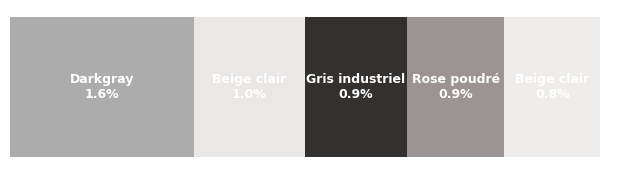

✅ Batch traité en 3.24 secondes pour 50 images
🎨 Palette moyenne pour le style 'industriel':


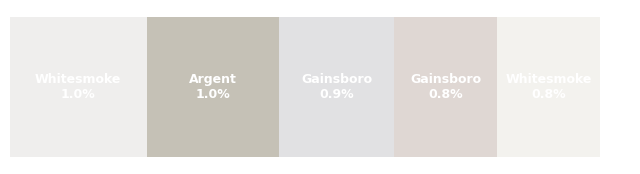

✅ Batch traité en 3.25 secondes pour 50 images
🎨 Palette moyenne pour le style 'minimaliste':


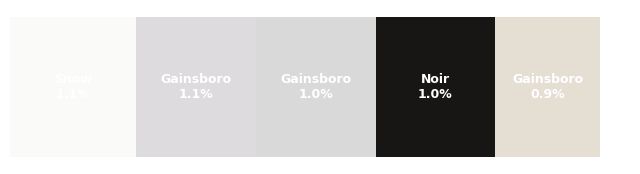

✅ Batch traité en 2.90 secondes pour 50 images
🎨 Palette moyenne pour le style 'moderne':


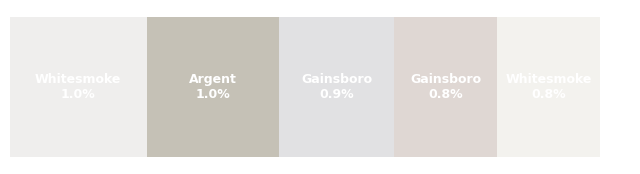

✅ Batch traité en 3.09 secondes pour 50 images
🎨 Palette moyenne pour le style 'royal':


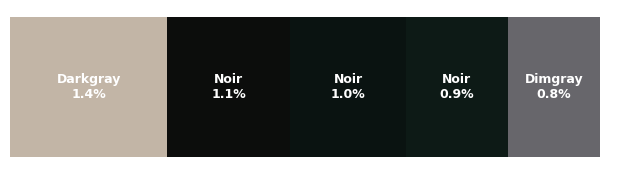

✅ Batch traité en 2.97 secondes pour 50 images
🎨 Palette moyenne pour le style 'rustique':


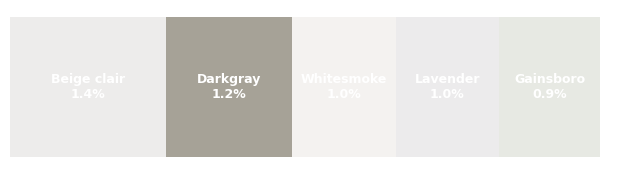

✅ Batch traité en 2.77 secondes pour 50 images
🎨 Palette moyenne pour le style 'vintage':


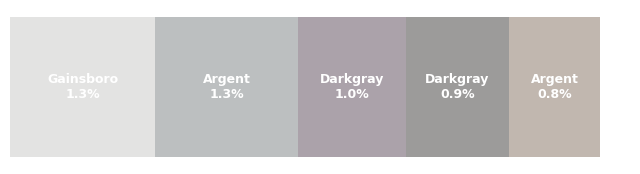

In [9]:
for style in STYLES:
    visualize_style_average_palette(style, top_n=5)
